In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


# Import Datasets
df_seq = pd.read_csv('pdb_data_seq_20.csv')
df_char = pd.read_csv('pdb_data_no_dups_20.csv')
print('Datasets have been loaded...')

Datasets have been loaded...


C:\Users\asus\AppData\Local\Temp\ipykernel_1664\3584225734.py:11: DtypeWarning: Columns (0,1,2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_seq = pd.read_csv('pdb_data_seq_20.csv')
C:\Users\asus\AppData\Local\Temp\ipykernel_1664\3584225734.py:12: DtypeWarning: Columns (0,1,2,3,7,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_char = pd.read_csv('pdb_data_no_dups_20.csv')


In [2]:
# Filter for only proteins
protein_char = df_char[df_char.macromoleculeType == 'Protein']
protein_seq = df_seq[df_seq.macromoleculeType == 'Protein']

# Select only necessary variables to join
protein_char = protein_char[['structureId','classification']]
protein_seq = protein_seq[['structureId','sequence']]
protein_seq.head()

,structureId,sequence
4,101M,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
7,102L,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...
8,102M,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
11,103L,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...
12,103M,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...


In [3]:
protein_char.head()

,structureId,classification
2,101M,OXYGEN TRANSPORT
4,102L,HYDROLASE(O-GLYCOSYL)
5,102M,OXYGEN TRANSPORT
7,103L,HYDROLASE(O-GLYCOSYL)
8,103M,OXYGEN TRANSPORT


In [4]:
# Join two datasets on structureId
model_f = protein_char.set_index('structureId').join(protein_seq.set_index('structureId'))
model_f.head()

,classification,sequence
structureId,,
01-Aug,THIOL PROTEASE,MEKKVLLTGFDPFGGETVNPSWEAVKRLNGAAEGPASIVSEQVPTV...
01-Aug,THIOL PROTEASE,MEKKVLLTGFDPFGGETVNPSWEAVKRLNGAAEGPASIVSEQVPTV...
01-Aug,THIOL PROTEASE,MEKKVLLTGFDPFGGETVNPSWEAVKRLNGAAEGPASIVSEQVPTV...
01-Aug,THIOL PROTEASE,MEKKVLLTGFDPFGGETVNPSWEAVKRLNGAAEGPASIVSEQVPTV...
01-Dec,BLOOD COAGULATION,APRLPQCQGDDQEKCLCNKDECPPGQCRFPRGDADPYCE


In [5]:
print('%d is the number of rows in the joined dataset' %model_f.shape[0])

38926 is the number of rows in the joined dataset


In [6]:
# Check NA counts
model_f.isnull().sum()

classification    0
sequence          1
dtype: int64

In [7]:
# Drop rows with missing values
model_f = model_f.dropna()
print('%d is the number of proteins that have a classification and sequence' %model_f.shape[0])

38925 is the number of proteins that have a classification and sequence


HYDROLASE                         4657
OXIDOREDUCTASE                    4015
TRANSFERASE                       3587
LYASE                             1634
IMMUNE SYSTEM                     1348
                                  ... 
REVERSE TRANSCRIPTASE                1
CHITIN-BINDING                       1
ISOMERASE/TRANSFERASE                1
ACETYLTRANSFERASE                    1
OXIDOREDUCTASE (H2O2 ACCEPTOR)       1
Name: classification, Length: 1533, dtype: int64


C:\Users\asus\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


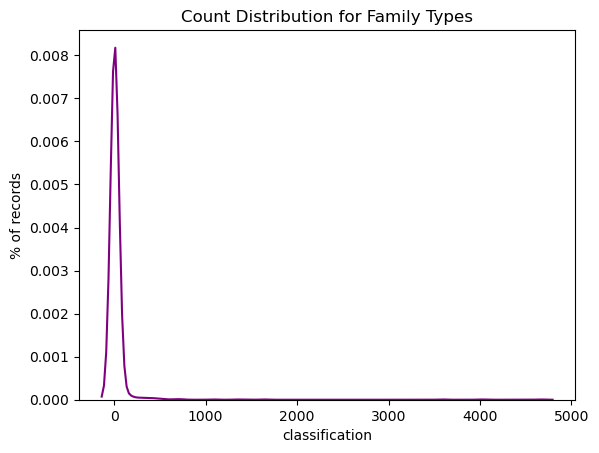

In [8]:
# Look at classification type counts
counts = model_f.classification.value_counts()
print(counts)

#plot counts
plt.figure()
sns.distplot(counts, hist = False, color = 'purple')
plt.title('Count Distribution for Family Types')
plt.ylabel('% of records')
plt.show()

In [9]:
# Get classification types where counts are over 1000
types = np.asarray(counts[(counts > 1000)].index)

# Filter dataset's records for classification types > 1000
data = model_f[model_f.classification.isin(types)]

print(types)
print('%d is the number of records in the final filtered dataset' %data.shape[0])

['HYDROLASE' 'OXIDOREDUCTASE' 'TRANSFERASE' 'LYASE' 'IMMUNE SYSTEM'
 'HYDROLASE/HYDROLASE INHIBITOR']
16326 is the number of records in the final filtered dataset


In [10]:
# 3). ----- Train Test Split -----

# Split Data
X_train, X_test,y_train,y_test = train_test_split(data['sequence'], data['classification'], test_size = 0.2, random_state = 1)

# Create a Count Vectorizer to gather the unique elements in sequence
vect = CountVectorizer(analyzer = 'char_wb', ngram_range = (4,4))

# Fit and Transform CountVectorizer
vect.fit(X_train)
X_train_df = vect.transform(X_train)
X_test_df = vect.transform(X_test)

#Print a few of the features
print(vect.get_feature_names()[-20:])

['zgar', 'ziar', 'zigi', 'ziwz', 'zkal', 'zkky', 'zknt', 'zkyh', 'zlik', 'zlzk', 'zpvm', 'zrgd', 'zrvi', 'ztvl', 'ztzk', 'zvbd', 'zvib', 'zvka', 'zwdl', 'zzvb']


C:\Users\asus\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [11]:
from sklearn.metrics import r2_score,mean_squared_error,accuracy_score,recall_score,precision_score,confusion_matrix


In [12]:
# will store result of each model.

result = pd.DataFrame(columns=['Model','Accuracy',  'Precision', 'Recall Score', 'F-1 Score'])


In [13]:
# 4). ------ Machine Learning Models ------
# SVM
prediction = dict()

from sklearn import svm
model = svm.SVC()
model.fit(X_train_df, y_train)
SVM_pred = model.predict(X_test_df)

In [14]:
# Compute precision, recall and f1 score
from sklearn.metrics import recall_score, precision_score, f1_score, classification_report

precision = precision_score(y_test, SVM_pred, average='weighted')
recall = recall_score(y_test, SVM_pred, average='weighted')
f1 = f1_score(y_test, SVM_pred, average='weighted')

print("Precision is", precision)
print("Recall is", recall)
print("F1 score is", f1)

Precision is 0.9206071710152197
Recall is 0.9066135946111451
F1 score is 0.9107591437442439


In [15]:
prediction["Support"] = accuracy_score(SVM_pred, y_test)
print( prediction['Support'])

0.9066135946111451


In [16]:
result = result.append(pd.Series({'Model':'SVM Classifier','Accuracy':prediction['Support'], 'Precision':precision, 'Recall Score':recall, 'F-1 Score':f1}),ignore_index=True)
result

C:\Users\asus\AppData\Local\Temp\ipykernel_1664\2948008605.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(pd.Series({'Model':'SVM Classifier','Accuracy':prediction['Support'], 'Precision':precision, 'Recall Score':recall, 'F-1 Score':f1}),ignore_index=True)


,Model,Accuracy,Precision,Recall Score,F-1 Score
0,SVM Classifier,0.906614,0.920607,0.906614,0.910759


In [17]:
# Naive bayes
prediction = dict()

# Naive Bayes Model
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(X_train_df, y_train)
NB_pred = model.predict(X_test_df)

precision = precision_score(y_test, NB_pred, average='weighted')
recall = recall_score(y_test, NB_pred, average='weighted')
f1 = f1_score(y_test, NB_pred, average='weighted')

print("Precision is", precision)
print("Recall is", recall)
print("F1 score is", f1)

Precision is 0.9345117990103983
Recall is 0.9246785058175138
F1 score is 0.9270497570395797


In [18]:
dt_test_accuracy = accuracy_score(y_test, NB_pred)

result = result.append(pd.Series({'Model':'Naive bayes','Accuracy':dt_test_accuracy, 'Precision':precision, 'Recall Score':recall, 'F-1 Score':f1}),ignore_index=True)
result

C:\Users\asus\AppData\Local\Temp\ipykernel_1664\1967050744.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(pd.Series({'Model':'Naive bayes','Accuracy':dt_test_accuracy, 'Precision':precision, 'Recall Score':recall, 'F-1 Score':f1}),ignore_index=True)


,Model,Accuracy,Precision,Recall Score,F-1 Score
0,SVM Classifier,0.906614,0.920607,0.906614,0.910759
1,Naive bayes,0.924679,0.934512,0.924679,0.927050


In [19]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train_df,y_train)
RFC_pred = model.predict(X_test_df)

precision = precision_score(y_test, RFC_pred, average='weighted')
recall = recall_score(y_test, RFC_pred, average='weighted')
f1 = f1_score(y_test, RFC_pred, average='weighted')

print("Precision is", precision)
print("Recall is", recall)
print("F1 score is", f1)

Precision is 0.9472932671324701
Recall is 0.9445805266380894
F1 score is 0.9455314250522809


In [20]:
dt_test_accuracy = accuracy_score(y_test, RFC_pred)

result = result.append(pd.Series({'Model':'Random Forest','Accuracy':dt_test_accuracy, 'Precision':precision, 'Recall Score':recall, 'F-1 Score':f1}),ignore_index=True)
result

C:\Users\asus\AppData\Local\Temp\ipykernel_1664\4244469933.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(pd.Series({'Model':'Random Forest','Accuracy':dt_test_accuracy, 'Precision':precision, 'Recall Score':recall, 'F-1 Score':f1}),ignore_index=True)


,Model,Accuracy,Precision,Recall Score,F-1 Score
0,SVM Classifier,0.906614,0.920607,0.906614,0.910759
1,Naive bayes,0.924679,0.934512,0.924679,0.927050
2,Random Forest,0.944581,0.947293,0.944581,0.945531


In [21]:
# Decision tree
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model.fit(X_train_df,y_train)
DTC_pred = model.predict(X_test_df)
precision = precision_score(y_test, DTC_pred, average='weighted')
recall = recall_score(y_test, DTC_pred, average='weighted')
f1 = f1_score(y_test, DTC_pred, average='weighted')

print("Precision is", precision)
print("Recall is", recall)
print("F1 score is", f1)

Precision is 0.927278873445862
Recall is 0.9277403551745255
F1 score is 0.9270845909793073


In [22]:
dt_test_accuracy = accuracy_score(y_test, DTC_pred)

result = result.append(pd.Series({'Model':'Decision Tree','Accuracy':dt_test_accuracy, 'Precision':precision, 'Recall Score':recall, 'F-1 Score':f1}),ignore_index=True)
result

C:\Users\asus\AppData\Local\Temp\ipykernel_1664\4153433392.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(pd.Series({'Model':'Decision Tree','Accuracy':dt_test_accuracy, 'Precision':precision, 'Recall Score':recall, 'F-1 Score':f1}),ignore_index=True)


,Model,Accuracy,Precision,Recall Score,F-1 Score
0,SVM Classifier,0.906614,0.920607,0.906614,0.910759
1,Naive bayes,0.924679,0.934512,0.924679,0.927050
2,Random Forest,0.944581,0.947293,0.944581,0.945531
3,Decision Tree,0.927740,0.927279,0.927740,0.927085


In [23]:
# Adaboost 
from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier()
model.fit(X_train_df,y_train)
ADA_pred = model.predict(X_test_df)
precision = precision_score(y_test, ADA_pred, average='weighted')
recall = recall_score(y_test, ADA_pred, average='weighted')
f1 = f1_score(y_test, ADA_pred, average='weighted')

print("Precision is", precision)
print("Recall is", recall)
print("F1 score is", f1)

Precision is 0.39615699288721645
Recall is 0.3643600734843846
F1 score is 0.29539590507539903


In [24]:
dt_test_accuracy = accuracy_score(y_test, ADA_pred)

result = result.append(pd.Series({'Model':'Adaboost','Accuracy':dt_test_accuracy, 'Precision':precision, 'Recall Score':recall, 'F-1 Score':f1}),ignore_index=True)
result

C:\Users\asus\AppData\Local\Temp\ipykernel_1664\2067327503.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(pd.Series({'Model':'Adaboost','Accuracy':dt_test_accuracy, 'Precision':precision, 'Recall Score':recall, 'F-1 Score':f1}),ignore_index=True)


,Model,Accuracy,Precision,Recall Score,F-1 Score
0,SVM Classifier,0.906614,0.920607,0.906614,0.910759
1,Naive bayes,0.924679,0.934512,0.924679,0.927050
2,Random Forest,0.944581,0.947293,0.944581,0.945531
3,Decision Tree,0.927740,0.927279,0.927740,0.927085
4,Adaboost,0.364360,0.396157,0.364360,0.295396


In [25]:
# KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
model.fit(X_train_df,y_train)
KNN_pred = model.predict(X_test_df)
precision = precision_score(y_test, KNN_pred, average='weighted')
recall = recall_score(y_test, KNN_pred, average='weighted')
f1 = f1_score(y_test, KNN_pred, average='weighted')
print("Precision is", precision)
print("Recall is", recall)
print("F1 score is", f1)

Precision is 0.8859090537577774
Recall is 0.812614819350888
F1 score is 0.8346864860982828


C:\Users\asus\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [26]:
dt_test_accuracy = accuracy_score(y_test, KNN_pred)

result = result.append(pd.Series({'Model':'KNN','Accuracy':dt_test_accuracy, 'Precision':precision, 'Recall Score':recall, 'F-1 Score':f1}),ignore_index=True)
result

C:\Users\asus\AppData\Local\Temp\ipykernel_1664\3748535209.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(pd.Series({'Model':'KNN','Accuracy':dt_test_accuracy, 'Precision':precision, 'Recall Score':recall, 'F-1 Score':f1}),ignore_index=True)


,Model,Accuracy,Precision,Recall Score,F-1 Score
0,SVM Classifier,0.906614,0.920607,0.906614,0.910759
1,Naive bayes,0.924679,0.934512,0.924679,0.927050
2,Random Forest,0.944581,0.947293,0.944581,0.945531
3,Decision Tree,0.927740,0.927279,0.927740,0.927085
4,Adaboost,0.364360,0.396157,0.364360,0.295396
5,KNN,0.812615,0.885909,0.812615,0.834686


In [27]:
# LogisticRegression
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train_df,y_train)
LGR_pred = model.predict(X_test_df)
precision = precision_score(y_test, LGR_pred, average='weighted')
recall = recall_score(y_test, LGR_pred, average='weighted')
f1 = f1_score(y_test, LGR_pred, average='weighted')
print("Precision is", precision)
print("Recall is", recall)
print("F1 score is", f1)

Precision is 0.9448091860831813
Recall is 0.9433557868952848
F1 score is 0.9439036116608348


C:\Users\asus\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [28]:
dt_test_accuracy = accuracy_score(y_test, LGR_pred)

result = result.append(pd.Series({'Model':'Logistic Regression','Accuracy':dt_test_accuracy, 'Precision':precision, 'Recall Score':recall, 'F-1 Score':f1}),ignore_index=True)
result

C:\Users\asus\AppData\Local\Temp\ipykernel_1664\567188770.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(pd.Series({'Model':'Logistic Regression','Accuracy':dt_test_accuracy, 'Precision':precision, 'Recall Score':recall, 'F-1 Score':f1}),ignore_index=True)


,Model,Accuracy,Precision,Recall Score,F-1 Score
0,SVM Classifier,0.906614,0.920607,0.906614,0.910759
1,Naive bayes,0.924679,0.934512,0.924679,0.927050
2,Random Forest,0.944581,0.947293,0.944581,0.945531
3,Decision Tree,0.927740,0.927279,0.927740,0.927085
4,Adaboost,0.364360,0.396157,0.364360,0.295396
5,KNN,0.812615,0.885909,0.812615,0.834686
6,Logistic Regression,0.943356,0.944809,0.943356,0.943904
